<a href="https://colab.research.google.com/github/stanimman/Simple/blob/master/Dog_Breed_Dataset_With_Plot_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5c7fa000 @  0x7fc5c16c92a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
True


In [2]:
!pip uninstall Pillow -y

!pip install Pillow

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [1]:
import PIL
print(PIL.PILLOW_VERSION)
import sys

5.3.0


In [2]:
!pip install kaggle-cli
!kg download -u 'stanimman' -p 'Legspinner@1' -c 'dog-breed-identification'

    100% |████████████████████████████████| 81kB 3.0MB/s 
    100% |████████████████████████████████| 5.3MB 5.8MB/s 
    100% |████████████████████████████████| 112kB 27.2MB/s 
    100% |████████████████████████████████| 92kB 26.7MB/s 
    100% |████████████████████████████████| 51kB 19.4MB/s 
  Running setup.py bdist_wheel for kaggle-cli ... - done
  Stored in directory: /root/.cache/pip/wheels/d5/bb/10/c1dd1b08c7433c943cb55c46367ae3f891415e8a37300ff8a7
  Running setup.py bdist_wheel for cliff ... - \ done
  Stored in directory: /root/.cache/pip/wheels/02/22/09/66f8c243f9c68dee7e6456a0fd6c117439a64394fdaf02d965
  Running setup.py bdist_wheel for configparser ... - done
  Stored in directory: /root/.cache/pip/wheels/a3/61/79/424ef897a2f3b14684a7de5d89e8600b460b89663e6ce9d17c
  Running setup.py bdist_wheel for PrettyTable ... - done
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Running setup.py bdist_wheel for pype

In [3]:
!ls

labels.csv.zip	sample_data  sample_submission.csv.zip	test.zip  train.zip


In [0]:
!unzip -q labels.csv.zip
!unzip -q train.zip

In [5]:
!unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
#%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [7]:
INPUT_SIZE = 224
NUM_CLASSES = 120
data_dir = '/content'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
#print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222


In [8]:
labels.groupby('breed').rank().head(5)

,id
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [9]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8) # Not clear how it sample equal prob nut I could see they are sampled with equal value for each class 
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape) # The shape is 121 because 120 class + Id (Column)

(8178, 121) (2044, 121)


In [10]:
valid.head()

breed,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000bec180eb18c7604dcecc8fe0dba07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0021f9ceb3235effd7fcde7f7538ed62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0042188c895a2f14ef64a918ed9c7b64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0097c6242c6f3071762d9f85c3ef1b2f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,00b7d114bc5166a629a3cc03d9329120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:


# class_element = np.bincount(classes) # Useful to get value count

In [0]:
img_names[0:9]

['/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/train/007b5a16db9d9ff9d7ad39982703e429.jpg',
 '/content/train/007b8a07882822475a4ce6581e70b1f8.jpg',
 '/content/train/0097c6242c6f3071762d9f85c3ef1b2f.jpg',
 '/content/train/00a862390341c5be090dd72bd2bc19ef.jpg',
 '/content/train/00cc68a50b2d016a6b29af628ea4e04b.jpg']

In [0]:
# probs = predictions["log_pred"][:,1]
# preds = np.argmax(predictions["log_pred"], axis=1)
# val_y = np.array(predictions["val_y"])
# img_names = predictions["img_names"]
# classes = predictions["classes"]

In [0]:
df = pd.DataFrame(valid.groupby('id').idxmax(axis=1).reset_index()) # group by is just a cheater bcoz all id is unique , after group by we taking the  ".idxmax() - e Return index of first occurrence of maximum over requested axis. NA/null values are excluded."
classes = list(df.iloc[:,2])



In [0]:
#image_path = list(df.iloc)

In [0]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].as_matrix().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [0]:
TRAIN_IMG_PATH = "/content/train"
#TEST_IMG_PATH = "/content/test"
LABELS_CSV_PATH = "/content/labels.csv"
SAMPLE_SUB_PATH = "/content/sample_submission.csv"

In [0]:
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# ds_trans = transforms.Compose([transforms.Scale(224),
#                                transforms.CenterCrop(224),
#                                transforms.ToTensor(),
#                                normalize])
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'TTA': transforms.Compose([
        transforms.Resize(256),
        transforms.FiveCrop(224),
        transforms.Lambda(lambda crops: 
                          torch.stack([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       (transforms.ToTensor()(crop)) for crop in crops]))
    ])
}

train_ds = DogsDataset(train, TRAIN_IMG_PATH, transform=data_transforms['train'])
valid_ds = DogsDataset(valid, TRAIN_IMG_PATH, transform=data_transforms['valid'])


train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

In [0]:
dataloaders = {"train": train_dl, "valid": valid_dl}

In [16]:
model = torchvision.models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:03<00:00, 54873003.89it/s]


In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
import torch.nn as nn
model.fc = nn.Linear(model.fc.in_features, 120)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.003)

In [0]:
from time import time
import copy
import sys
dataset_sizes = {"train": len(train_ds),"valid":len(valid_ds)}

In [0]:
## Train model with schedular included and some changes to it track the loss hostory 


def train_model(model, criterion, optimizer, dataloaders, device, 
                dataset_sizes, num_classes, scheduler = None, num_epochs=25):
    '''Trains an image classification model
    Args:
        model: Network which has to be trained
        criterion: Lossfunction
        optimizer: pytorch optimizer function
        dataloaders: pytorch dataloader
        device: "cuda" or "cpu"
        dataset_sizes: Dictionary containing number of images in train and
                        valid
        num_classes: Number of classes in dataset
        scheduler: LR scheduler
        num_epochs: number of epochs
    Returns:
        model: trained model
        lr_hist: history of learning rate used in training
    '''
    lr_hist = []
    since = time()
    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Count training and validation examples
    train_examples = len(dataloaders['train'].dataset)
    valid_examples = len(dataloaders['valid'].dataset)

    train_bs = dataloaders['train'].batch_size
    valid_bs = dataloaders['valid'].batch_size
    
    # Calculate number of minibatches for training and validation
    num_minibatch = {'train': int(np.ceil(train_examples / train_bs)), 
                     'valid': int(np.ceil(valid_examples / valid_bs))}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            mini_batch = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                mini_batch += 1
                # Print status bar
                if phase == 'train':
                    mini_batch_comp = int((mini_batch/
                                           num_minibatch[phase])*100)//2
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-50s] %d%%" %(phase, 
                                     "="*mini_batch_comp, 2*mini_batch_comp))
                else:
                    mini_batch_comp = int((mini_batch/
                                           num_minibatch[phase])*100)//5
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-20s] %d%%" %(phase, 
                                     "="*mini_batch_comp, 5*mini_batch_comp))

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # Update schedule if scheduler is given
                        if scheduler is not None:
                            scheduler.step()
                            lr_ = []
                            for group in optimizer.param_groups:
                                lr_.append(group["lr"])
                            lr_hist.append(lr_)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("")
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, lr_hist

In [23]:
num_classes = 120
model, lr_hist = train_model(model, criterion, optimizer, dataloaders, device, 
                             dataset_sizes, num_classes,num_epochs=7) # I am not passing schedular here


Epoch 1/7
----------
train[==================================================] 100%
train Loss: 2.8221583205465874 Acc: 0.4492540963560773
valid[====================] 100%
valid Loss: 1.132300692003534 Acc: 0.7583170254403131

Epoch 2/7
----------
train[==================================================] 100%
train Loss: 2.273738283608414 Acc: 0.5865737344093911
valid[====================] 100%
valid Loss: 1.277001686000544 Acc: 0.7592954990215264

Epoch 3/7
----------
train[==================================================] 100%
train Loss: 2.298706967255165 Acc: 0.6151870873074101
valid[====================] 100%
valid Loss: 1.4530472571719182 Acc: 0.772504892367906

Epoch 4/7
----------
train[==================================================] 100%
train Loss: 2.2451409572755017 Acc: 0.6402543409146491
valid[====================] 100%
valid Loss: 1.3509887756666792 Acc: 0.7891389432485323

Epoch 5/7
----------
train[==================================================] 100%
train Los

In [0]:
torch.save(model, "dogsBreed_resnet34")

In [0]:
model = torch.load("dogsBreed_resnet34")

In [0]:
valid_dl_no_shuffle = DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=4)

In [0]:
import torch.nn.functional as F
def prediction_fn(model, valid_dl,device):
  since = time()
  model = model.to(device)
  phase ='valid'
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  results = {}
  results["log_pred"] = np.empty((0,120), float)
  mini_batch = 1
  # Count training and validation examples
  #train_examples = len(dataloaders['train'].dataset)
  valid_examples = len(valid_dl.dataset)

  #train_bs = dataloaders['train'].batch_size
  valid_bs = valid_dl.batch_size

  # Calculate number of minibatches for training and validation
  num_minibatch = { #'train': int(np.ceil(train_examples / train_bs)), 
                   'valid': int(np.ceil(valid_examples / valid_bs))}
  
  for inputs, labels in valid_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                # Print status bar
                if phase == 'train':
                    mini_batch_comp = int((mini_batch/num_minibatch[phase])*100)//2
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-50s] %d%%" %(phase, "="*mini_batch_comp, 2*mini_batch_comp))
                else:
                    mini_batch_comp = int((mini_batch/num_minibatch[phase])*100)//5
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-20s] %d%%" %(phase, "="*mini_batch_comp, 5*mini_batch_comp))

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = F.softmax(outputs, 1)
                    outputs = outputs.cpu().data.numpy()
                    results["log_pred"] = np.append(results["log_pred"], outputs, axis = 0)
                    
                mini_batch += 1
  
  time_elapsed = time() - since
  print("")
  print(f'Time taken for prediction {time_elapsed // 60}m {time_elapsed % 60}s')

  return results

In [27]:
predictions = prediction_fn(model,valid_dl_no_shuffle,device)

valid[====================] 100%
Time taken for prediction 0.0m 30.057297468185425s


In [0]:
# Image Names
Id = list( valid.iloc[:,0])
file_ext = '.jpg'
IMG_PATH = "/content/train/"
img_names = [s + file_ext for s in Id]
img_names = [IMG_PATH + s for s in img_names]

# val_y
mat = valid.iloc[:,1:].as_matrix().astype('float')
val_y = np.argmax(mat, axis=1)

# classses
df = pd.DataFrame(valid.groupby('id').idxmax(axis=1).reset_index()) # group by is just a cheater bcoz all id is unique , after group by we taking the  ".idxmax() - e Return index of first occurrence of maximum over requested axis. NA/null values are excluded."
classes = list(df.iloc[:,2])

# Prob 
probs = [predictions['log_pred'][idx][item] for idx,item in enumerate(val_y)]

# Preds_val
preds = np.argmax(predictions["log_pred"], axis=1)


In [0]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

In [0]:
def rand_by_correct(is_correct): 
    return rand_by_mask((preds == val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: 
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(img_names, val_y, idx): 
    return np.array(PIL.Image.open(img_names[idx]))

In [0]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(img_names, val_y, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    #title_names = [classes[x] for x in idxs]
    #title_concat = [m+str(n) for m,n in zip(title_names , title_probs)]
    print(title)
    if len(imgs) > 0:
        return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))
    else:
        print('Not Found.')

Correctly classified


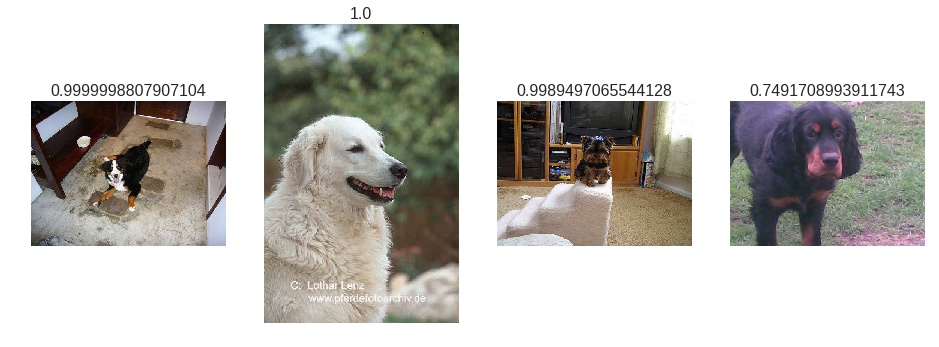

In [34]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


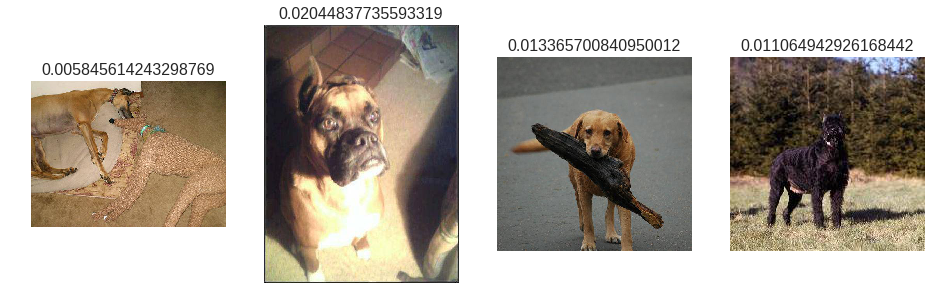

In [35]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * [probs[x] for x in idxs])[:4]]

def most_by_correct(y, is_correct): 
    if (y==1) == is_correct:
        mult = -1
    else:
        mult = 1
    return most_by_mask(((preds == val_y)==is_correct) & (val_y == y), mult)

Most correct bedlington_terrier


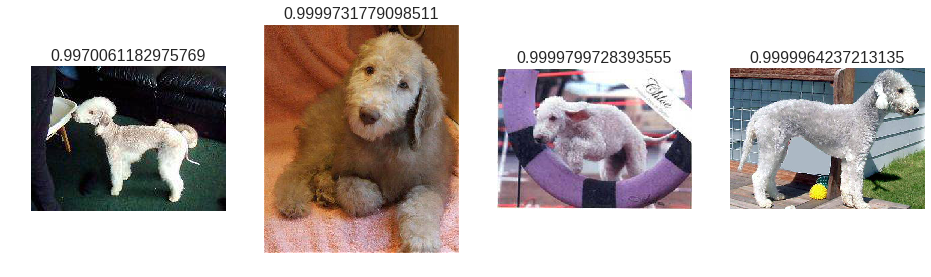

In [37]:
plot_val_with_title(most_by_correct(10, True), "Most correct "+valid.columns[11])

In [42]:
plot_val_with_title(most_by_correct(12, False), "Most incorrect "+valid.columns[12])

Most incorrect bernese_mountain_dog
Not Found.


In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4] # need to check why probs is not working need to change it accordingly
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## LR Finder

In [0]:
class lr_finder():
    
    """Implementation of LR Find function explained in the paper:
        https://arxiv.org/abs/1506.01186
        Tries a range of Learning Rates and returns the loss for
        the entire range.
        
        Args:
            model: Network for which the LR has to be found
            criterion: Loss function
            optimizer: pytorch optimizer
                Optimizer can have different param_groups for
                    different layers of the network to have 
                    different LRs. The layers should be in order
                    of closeness to the input. i.e. the layer 
                    closest to the input should be the first and
                    the last layer before the loss function should
                    be the last
            dataloaders: Dictionary containing DataLoader for "train"
            device: "CPU" or "CUDA"
            factor: Factor by which the LR has to be reduced for the
                earlier groups. For e.g. if the factor is 10, then if 
                the last group has a LR of 0.2, the group ahead of it 
                will have a LR of 0.02 and the one ahead of the second
                group will have an LR of 0.002 and so on.
    """
    
    def __init__(self, model, criterion, optimizer, dataloaders, device, factor=10):
        
        model = model.to(device)
        self.model = model.train()
        self.criterion = criterion
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.device = device
        self.results = None
        self.factor = factor
        
    def fit(self):
        
        # Count number of examples in train dataset
        model = self.model
        criterion = self.criterion
        optimizer = self.optimizer
        device = self.device
        train_examples = len(self.dataloaders['train'].dataset)
        train_bs = self.dataloaders['train'].batch_size
        # Count number of mini batches
        mini_batches = train_examples // train_bs
        increment = 16 / mini_batches ## Why 16 what is the significance ?
        
        # Start with a very low LR for the last layer
        lr_hist = []
        # Save loss history of the last layer
        loss_hist = []
        cur_lr = 1e-5
        
        mini_batch = 0
        for inputs, labels in self.dataloaders['train']:
            
            # Print status bar
            mini_batch_comp = int((mini_batch/mini_batches)*100)//2
            sys.stdout.write('\r')
            sys.stdout.write("[%-50s] %d%%" %("="*mini_batch_comp, 2*mini_batch_comp))
            mini_batch += 1
            
            
            
            # Set differential learning rates for various param groups based 
            # on factor value
            fa = 0
            for pg in optimizer.param_groups[::-1]:
                pg['lr'] = cur_lr / (self.factor ** fa)
                fa += 1
            lr_ = []
            for pg in optimizer.param_groups:
                lr_.append(pg['lr'])
            lr_hist.append(lr_)
            optimizer.zero_grad()
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            loss_hist.append(loss.item())
            cur_lr = cur_lr + (lr_hist[-1][-1] * increment)
            
            if cur_lr == 0:
                cur_lr += increment
            
            # Stop iteration at a LR of 1e1
            if cur_lr > 10:
                break
                
            # Stop iteration is loss is getting too high
            if (loss > (5*loss_hist[0])) & (cur_lr > .1):
                break
            
            if (lr_hist[-1][-1] * 10 - cur_lr) < (increment * lr_hist[-1][-1]):
                # Reset when LR is reduced by a factor of 10 
                cur_lr = round(lr_hist[-1][-1]*10, 8)
        
        if len(lr_hist) > len(loss_hist):
            lr_hist.pop(-1)
                
        self.results = {'lr': lr_hist, 'loss': loss_hist}
        self.results['loss'] = self.moving_average()
                     
    def plot_lr(self):
        
        # Plot LR vs Loss
        if self.results:
            lr_ = [i[-1] for i in self.results["lr"]]
            plt.plot(lr_, self.results['loss'])
            plt.xscale("log")
            plt.show()
        else:
            print("Results not available")
            
    def moving_average(self):
        # Smoothen the loss by calculating moving average
        loss_hist = np.cumsum(self.results['loss'])
        loss_hist /= np.arange(1, len(loss_hist)+1)
        return loss_hist
    
    def lr_schedule(self, group = -1):
        # Plot LR schedule
        lr_ = [i[group] for i in self.results["lr"]]
        plt.plot(lr_)

In [0]:
# # Create param groups and set differential learning rate

# for param in model.parameters():
#     param.requires_grad = True

# group1 = list(model.layer1.parameters()) + list(model.layer2.parameters())
# group2 = list(model.layer3.parameters()) + list(model.layer4.parameters())
# group3 = list(model.fc.parameters())

# optimizer = optim.Adam([{'params': group1, 'lr': 1e-4}, 
#                         {'params': group2, 'lr': 1e-3}, 
#                         {'params': group3, 'lr': 1e-2}])

In [82]:
# print(len(list(model.layer1.parameters())))
# print(len(list(model.layer2.parameters())))
# print(len(group1))

18
27
45


In [84]:
# print(lr_hist[-1][-1])

38144.94035557983


In [0]:
# Understanding the LR Finder 

# Set differential learning rates for various param groups based 
# on factor value
# factor = 10
# cur_lr = 1e-2
# mini_batches = 160
# increment = 16 / mini_batches ## Why 16 what is the significance ?
# lr_hist = []

# for i in range(mini_batches):
 
  
#   fa = 0
#   for pg in optimizer.param_groups[::-1]:
#       #print('Before :{}'.format(pg['lr']))
#       pg['lr'] = cur_lr / (factor ** fa)
#       #print('After :{}, factor : {}'.format(pg['lr'],fa))
#       fa += 1
#   lr_ = []
#   for pg in optimizer.param_groups:
#       lr_.append(pg['lr'])
#   lr_hist.append(lr_)
#   cur_lr = cur_lr + (lr_hist[-1][-1] * increment)
  
#   print('Current_Learning Rate : {} , lr_hist : {} '.format(cur_lr,lr_hist))

In [0]:
model = torchvision.models.resnet101(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 120)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01) # This is not working
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)


In [0]:
lr_find = lr_finder(model, criterion, optimizer, dataloaders, device)

In [51]:
lr_find.fit()

[=======================================           ] 78%

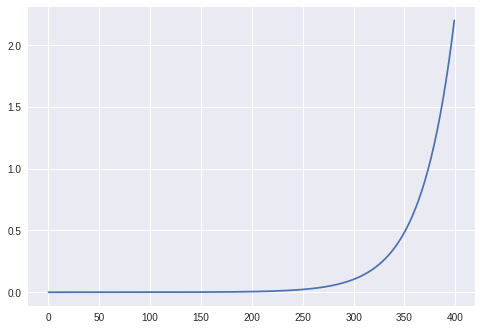

In [52]:
lr_find.lr_schedule()

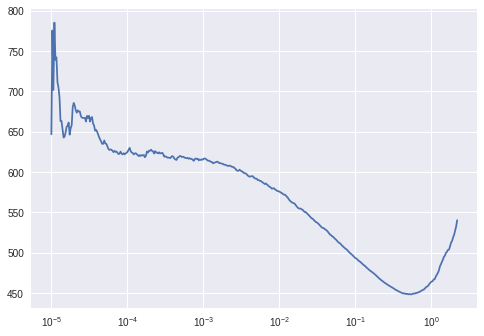

In [53]:
lr_find.plot_lr()

In [0]:
model = torchvision.models.resnet101(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 120)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01) # This is not working
# Using the learning obtained from the above graph 
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

In [59]:
model, lr_hist = train_model(model, criterion, optimizer, dataloaders, device, 
                             dataset_sizes, num_classes,num_epochs=5)  # we could see improvement over the previous accuracy bcoz the learning is obtained from the LR Finder

Epoch 1/5
----------
train[==================================================] 100%
train Loss: 12.782461246729305 Acc: 0.5857177794081683
valid[====================] 100%
valid Loss: 8.043203748602224 Acc: 0.7769080234833659

Epoch 2/5
----------
train[==================================================] 100%
train Loss: 12.193467429401998 Acc: 0.6024700415749572
valid[====================] 100%
valid Loss: 8.386320808395714 Acc: 0.7744618395303327

Epoch 3/5
----------
train[==================================================] 100%
train Loss: 12.721698951767838 Acc: 0.6107850330154072
valid[====================] 100%
valid Loss: 7.253141133519302 Acc: 0.7950097847358121

Epoch 4/5
----------
train[==================================================] 100%
train Loss: 12.676312237620849 Acc: 0.6173881144534116
valid[====================] 100%
valid Loss: 9.154509348412082 Acc: 0.7969667318982387

Epoch 5/5
----------
train[==================================================] 100%
train Lo

In [0]:
torch.save(model, "dogsBreed_resnet101")

In [0]:
# Confuses many models lets hold it now a while
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
#         transforms.RandomRotation(degrees=10, resample=False, expand=False, center=None),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'valid': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'TTA': transforms.Compose([
#         transforms.Resize(256),
#         transforms.FiveCrop(224),
#         transforms.Lambda(lambda crops: 
#                           torch.stack([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                                        (transforms.ToTensor()(crop)) for crop in crops]))
#     ])
# }

In [0]:
# train_ds = DogsDataset(train, TRAIN_IMG_PATH, transform=data_transforms['train'])
# valid_ds = DogsDataset(valid, TRAIN_IMG_PATH, transform=data_transforms['valid'])


# train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
# valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=True, num_workers=4)

# dataloaders = {"train": train_dl, "valid": valid_dl}

In [0]:
from torch.optim import Optimizer
class _LRScheduler_(object):
    # Modified code from torch.optim.lr_scheduler
    def __init__(self, optimizer, last_batch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_batch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_batch + 1)
        self.last_batch = last_batch

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.

        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_lr(self):
        raise NotImplementedError

    def step(self, batch=None):
        if batch is None:
            batch = self.last_batch + 1
        self.last_batch = batch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [0]:
class CosineAnnealingLR_(_LRScheduler_):
    # Modified code from torch.optim.lr_scheduler
    r"""Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:

    .. math::

        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))

    When last_epoch=-1, sets initial lr as lr.

    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. Note that this only
    implements the cosine annealing part of SGDR, and not the restarts.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.

    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_max, eta_min=0, last_batch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(CosineAnnealingLR_, self).__init__(optimizer, last_batch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_batch / self.T_max)) / 2
                for base_lr in self.base_lrs]

In [0]:
class SGDR(CosineAnnealingLR_):
    r"""Implements cosine annealing of LR
    Args:
        iterations: no. of iterations after which LR has to be reset
            in general iterations must be equal to no. of minibatches in 
            a training epoch
        cycle_mult: factor by which the iteration cycle has to be 
            increased after every cycle. Default: 1
    """
    def __init__(self, optimizer, T_max, eta_min = 0, last_batch = -1, cycle_mult = 1):
        self.cycle_mult = cycle_mult
        super(SGDR, self).__init__(optimizer, T_max, eta_min, last_batch)
        
    def step(self, batch=None):
        if batch is None:
            batch = self.last_batch + 1
        self.last_batch = batch
        if ((self.last_batch%self.T_max) == 0) & (self.last_batch != 0):
            # Reset after T_max number of iterations are reached
            self.last_batch = 0
            self.T_max = self.T_max * self.cycle_mult
            # Increase T_max by cycle_mult after each cycle
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [0]:
# Now try unfreezing all layer and use SGDR to improve the model still more

# I am savnig the model to be careful 


In [0]:
#Now Try SGDR to find better  result only last layer I am using the transformation that I used for intial training

model = torch.load("dogsBreed_resnet101")
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
  param.requires_grad = True
  
optimizer = optim.Adam(model.fc.parameters(),lr=1e-3) # Got this lr from previous LR finder

scheduler = SGDR(optimizer = optimizer, T_max = 360, cycle_mult = 2)

In [72]:
model, lr_hist = train_model(model, criterion, optimizer, dataloaders, device, 
                             dataset_sizes, num_classes, scheduler, num_epochs=7)

Epoch 1/7
----------
train[==================================================] 100%
train Loss: 7.097713775406201 Acc: 0.7196135974565909
valid[====================] 100%
valid Loss: 4.189737620419019 Acc: 0.8561643835616438

Epoch 2/7
----------
train[==================================================] 100%
train Loss: 6.7614347047868755 Acc: 0.731474688187821
valid[====================] 100%
valid Loss: 7.067765182711607 Acc: 0.8454011741682974

Epoch 3/7
----------
train[==================================================] 100%
train Loss: 6.252994189258891 Acc: 0.7428466617754953
valid[====================] 100%
valid Loss: 6.569455350215188 Acc: 0.847358121330724

Epoch 4/7
----------
train[==================================================] 100%
train Loss: 6.319539281668305 Acc: 0.7386891660552702
valid[====================] 100%
valid Loss: 5.602246816377583 Acc: 0.8365949119373777

Epoch 5/7
----------
train[==================================================] 100%
train Loss: 5

In [0]:
torch.save(model, "dogsBreed_resnet101_SGDR")

In [0]:
# Find LR with the three layer grouping
model = torch.load("dogsBreed_resnet101_SGDR")

for param in model.parameters():
    param.requires_grad = False

# Create param groups and set differential learning rate
#group1 = list(model.layer1.parameters()) + list(model.layer2.parameters())
group2 = list(model.layer4.parameters())
group3 = list(model.fc.parameters())

for param in group2:
  param.requires_grad = True

for param in group3:
  param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([
                        #{'params': group1, 'lr': 1e-4}, 
                        {'params': group2, 'lr': 1e-3}, 
                        {'params': group3, 'lr': 1e-2}])
lr_find = lr_finder(model, criterion, optimizer, dataloaders, device)

In [87]:
lr_find.fit()

[==========================================        ] 84%

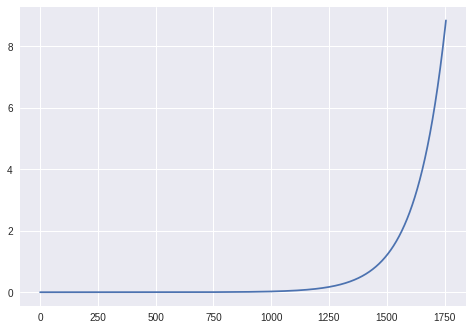

In [88]:
# Lr Schedule of last (FC) layer
lr_find.lr_schedule()

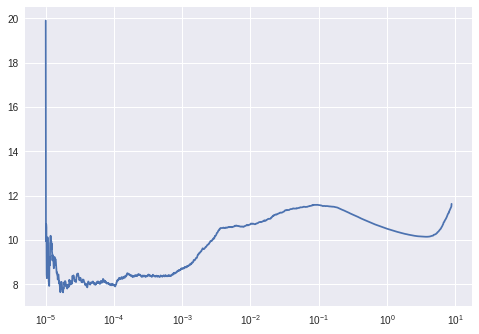

In [89]:
lr_find.plot_lr()

In [0]:
# Find LR with the three layer grouping
model = torch.load("dogsBreed_resnet101_SGDR")

# Unfreeze the layers
for param in model.parameters():
    param.requires_grad = False
    
# Create param groups and set differential learning rate
#group1 = list(model.layer1.parameters()) + list(model.layer2.parameters())
group2 = list(model.layer4.parameters())
group3 = list(model.fc.parameters())


for param in group2:
  param.requires_grad = True

for param in group3:
  param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([
                        #{'params': group1, 'lr': 1e-3}, 
                        {'params': group2, 'lr': 1e-4}, 
                        {'params': group3, 'lr': 1e-3}])

scheduler = SGDR(optimizer = optimizer, T_max = 360, cycle_mult = 2)

In [93]:
scheduler = None
#num_classes = 120
model, lr_hist = train_model(model, criterion, optimizer, dataloaders, device, 
                             dataset_sizes, num_classes, scheduler, num_epochs=7)

Epoch 1/7
----------
train[==================================================] 100%
train Loss: 1.73714263005445 Acc: 0.6018586451455123
valid[====================] 100%
valid Loss: 14.844104341382558 Acc: 0.6942270058708414

Epoch 2/7
----------
train[==================================================] 100%
train Loss: 1.4728502774664411 Acc: 0.6385424309122035
valid[====================] 100%
valid Loss: 5.61709755096118 Acc: 0.6996086105675147

Epoch 3/7
----------
train[==================================================] 100%
train Loss: 1.3010325670956575 Acc: 0.6713132795304476
valid[====================] 100%
valid Loss: 9.664156575740083 Acc: 0.6956947162426614

Epoch 4/7
----------
train[==================================================] 100%
train Loss: 1.2994062362020569 Acc: 0.6740034238200049
valid[====================] 100%
valid Loss: 10.27963267997957 Acc: 0.6893346379647749

Epoch 5/7
----------
train[==================================================] 100%
train Loss

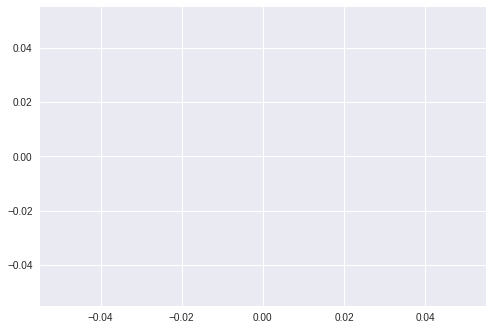

In [94]:

# Lr schedule of last layer (FC)
lr_ = [i[-1] for i in lr_hist]
plt.plot(lr_)
plt.show()

In [0]:
import os
import sys
import PIL
import math
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
from time import time
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from functools import partial
import torch.nn.functional as F
import matplotlib.pyplot as plt
from bisect import bisect_right
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models, transforms